In [1]:
!pip install yahoo_fin
!pip install mplfinance
!pip install wbdata

  Obtaining dependency information for wbdata from https://files.pythonhosted.org/packages/f0/60/fa9661d0480d6f62642feeff217b86b60946cba8c7f04d35d6e342ef4309/wbdata-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for backoff<3.0.0,>=2.2.1 from https://files.pythonhosted.org/packages/df/73/b6e24bd22e6720ca8ee9a85a0c4a2971af8497d8f3193fa05390cbd46e09/backoff-2.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6.0.0,>=5.3.2 from https://files.pythonhosted.org/packages/fb/2b/a64c2d25a37aeb921fddb929111413049fc5f8b9a4c1aefaffaafe768d54/cachetools-5.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for dateparser<2.0.0,>=1.2.0 from https://files.pythonhosted.org/packages/a4/29/db12aa4dda81580be1999824a689bd52aa40061fc12c9ccdc3feab5ea718/dateparser-1.2.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for shelved-cache<0.4.0,>=0.3.1 from https://files.pythonhosted.org/packages/09/b6/621bc73492accf30a584291c45a4ce

In [2]:
import webbrowser
import datetime
import yahoo_fin.stock_info as si
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ta

In [3]:
ma = si.get_day_most_active()
print('\n', ma.columns,
      '\n\n', ma[['Symbol', 'Name', 'Volume']][:40])


 Index(['Symbol', 'Name', 'Price (Intraday)', 'Change', '% Change', 'Volume',
       'Avg Vol (3 month)', 'Market Cap', 'PE Ratio (TTM)'],
      dtype='object') 

    Symbol                                               Name      Volume
0     GME                                     GameStop Corp.  73518000.0
1     NIO                                           NIO Inc.  71337000.0
2    NVDA                                 NVIDIA Corporation  50588000.0
3    TSLA                                        Tesla, Inc.  46300000.0
4    MARA                    Marathon Digital Holdings, Inc.  44754000.0
5    PLTR                         Palantir Technologies Inc.  41055000.0
6     AMD                       Advanced Micro Devices, Inc.  34361000.0
7    NVAX                                      Novavax, Inc.  32512000.0
8    HOOD                            Robinhood Markets, Inc.  29120000.0
9    LYFT                                         Lyft, Inc.  28204000.0
10   RIOT                       


 Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object') 

 DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-05-23', '2024-05-24', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31', '2024-06-03', '2024-06-04',
               '2024-06-05', '2024-06-06'],
              dtype='datetime64[ns]', length=862, freq=None)


C:\Users\mixas\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


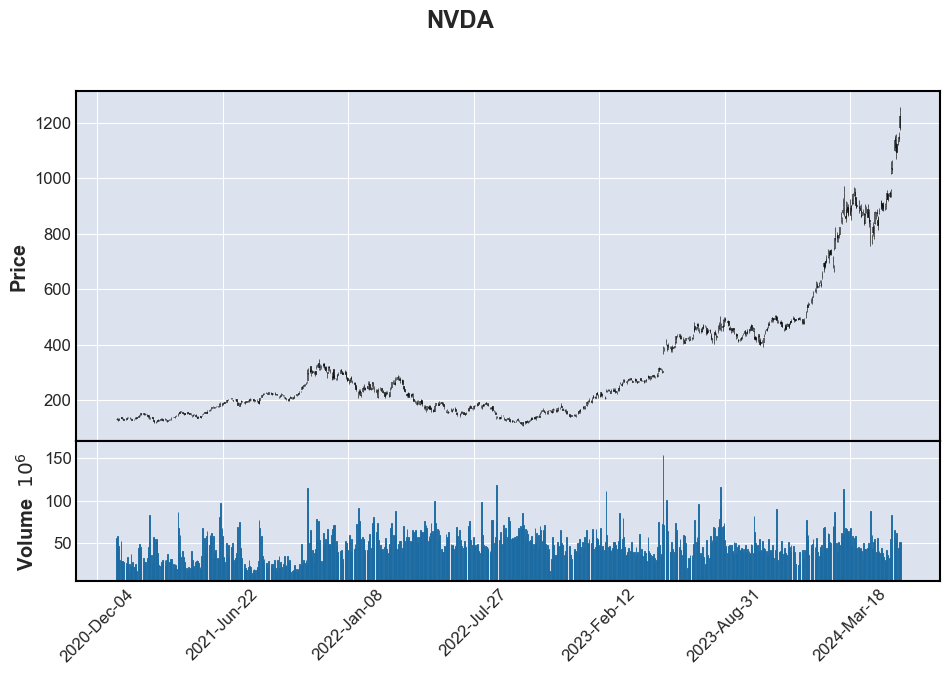

In [4]:
# get data >>>
#tcr='SNOW'
tcr='NVDA'

'''
start='2021-1-1'
'''
# three years period >>
start = str( datetime.date.today().year-3 )

df=si.get_data(tcr, start_date=start, interval='1d')

print('\n', df.columns, '\n\n', df.index)

mpf.plot(df, type='candle', volume=True,
         main_panel=0, volume_panel=1, figsize=(12,7),
         show_nontrading=True, title=tcr)

In [5]:
# Initialize the short and long windows
short_window = 10
long_window = 30
price = 'adjclose'

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ta.trend.sma_indicator(df[price],
                                               window=short_window)

# Create long simple moving average over the long window
signals['long_mavg'] = ta.trend.sma_indicator(df[price],
                                               window=long_window)
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:],
                                            1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals,'\n\n',
      pd.crosstab(signals.signal, signals.positions))

            signal   short_mavg   long_mavg  positions
2021-01-04     0.0          NaN         NaN        NaN
2021-01-05     0.0          NaN         NaN        0.0
2021-01-06     0.0          NaN         NaN        0.0
2021-01-07     0.0          NaN         NaN        0.0
2021-01-08     0.0          NaN         NaN        0.0
...            ...          ...         ...        ...
2024-05-31     1.0  1036.721985  926.395994        0.0
2024-06-03     1.0  1059.242987  939.329327        0.0
2024-06-04     1.0  1080.899988  951.635661        0.0
2024-06-05     1.0  1107.953992  964.974662        0.0
2024-06-06     1.0  1133.219446  978.487480        0.0

[862 rows x 4 columns] 

 positions  -1.0   0.0   1.0
signal                     
0.0          16   321     0
1.0           0   507    17


In [6]:
## short and long moving averages,
## together with the buy and sell signals

s = signals.index.min()
e = signals.index.max()
print('\nTime period to plot >>>\n', s,'\n', e)


Time period to plot >>>
 2021-01-04 00:00:00 
 2024-06-06 00:00:00


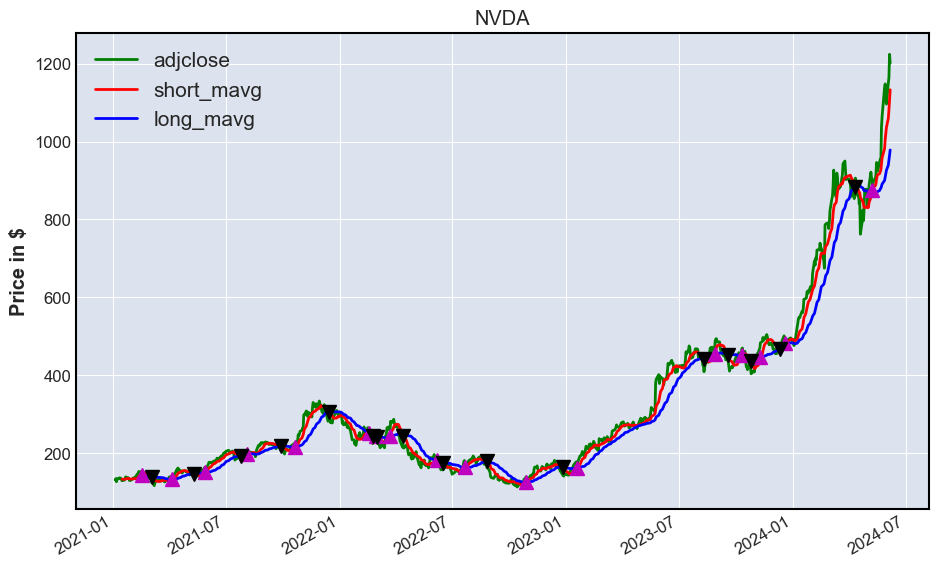

In [7]:
sp = signals.loc[s:e,]
dfp = df.loc[s:e,]

# Initialize the plot figure
fig = plt.figure(figsize=(11,7))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
dfp[price].plot(ax=ax1, color='g', lw=2., label=price)

# Plot the short and long moving averages
sp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., title=tcr,
                                     color=['r','b'])

# Plot the buy signals
ax1.plot(sp.loc[sp.positions == 1.0].index, 
         sp.short_mavg[sp.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(sp.loc[sp.positions == -1.0].index, 
         sp.short_mavg[sp.positions == -1.0],
         'v', markersize=10, color='k')
plt.legend(loc='best', fontsize=15)

In [8]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=sp.index).fillna(0.0)

# Would you buy *spd* shares a day?
spd = 100
positions[tcr] = spd*sp.signal
'''
print('\n',pd.crosstab(sp.signal, sp.positions))
print('\n',sp.groupby(by=['signal']).sum())
'''
  
# Initialize the portfolio with value owned, column *tcr*
# (store the market value of an open position) 
portfolio = positions.multiply(dfp[price], axis=0)

# Store the difference in shares owned
# (= +- *spd* in days when position was changed)
pos_diff = positions.diff()
'''
print('\n',pd.crosstab(positions[tcr], pos_diff[tcr]))
'''

# `holdings` in portfolio
# .sum(axis=1) --- сумма элементов в строках после умножения
portfolio['holdings'] = (positions.multiply(dfp[price],
                                            axis=0)).sum(axis=1)

# `cash` in portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(dfp[price],
                                                         axis=0)).sum(axis=1).cumsum()   

# `total` portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# `returns` of portfolio
portfolio['R'] = portfolio['total'].pct_change()
portfolio['r'] = np.log1p(portfolio.R)
# cumulative returns >>
portfolio["Rc"] = (portfolio.R + 1).cumprod()
portfolio["rc"] = portfolio.r.cumsum()

# Print the first lines of `portfolio`
print(portfolio)

                     NVDA       holdings          cash         total  \
2021-01-04       0.000000       0.000000  10000.000000  10000.000000   
2021-01-05       0.000000       0.000000  10000.000000  10000.000000   
2021-01-06       0.000000       0.000000  10000.000000  10000.000000   
2021-01-07       0.000000       0.000000  10000.000000  10000.000000   
2021-01-08       0.000000       0.000000  10000.000000  10000.000000   
...                   ...            ...           ...           ...   
2024-05-31  109632.995605  109632.995605 -25274.739838  84358.255768   
2024-06-03  115000.000000  115000.000000 -25274.739838  89725.260162   
2024-06-04  116436.999512  116436.999512 -25274.739838  91162.259674   
2024-06-05  122440.002441  122440.002441 -25274.739838  97165.262604   
2024-06-06  120215.454102  120215.454102 -25274.739838  94940.714264   

                   R         r        Rc        rc  
2021-01-04       NaN       NaN       NaN       NaN  
2021-01-05  0.000000  0.00000

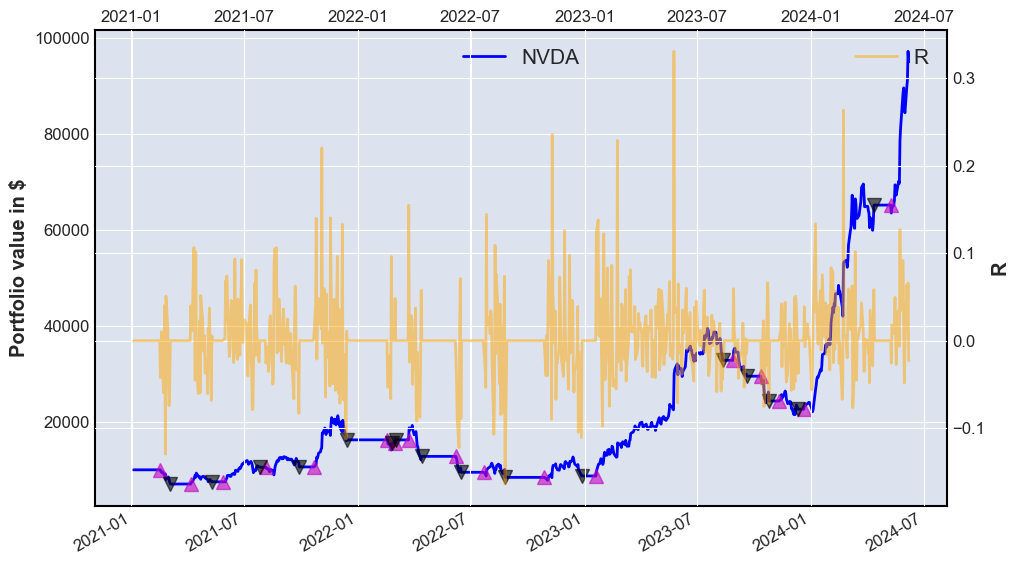

In [9]:
# visualize the portfolio value & returns >>>

# Create a figure
fig = plt.figure(figsize=(11,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2., label=tcr, color='b')
plt.legend(loc='upper center', fontsize=15)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.6)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.6)

pl="R"
'''
pl="r"
'''
ax2=fig.add_subplot(111, ylabel=pl, frame_on=False)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.yaxis.set_label_position('right')
ax2.plot(portfolio[pl], color='orange', alpha=0.5, label=pl)
plt.legend(loc='best', fontsize=15)

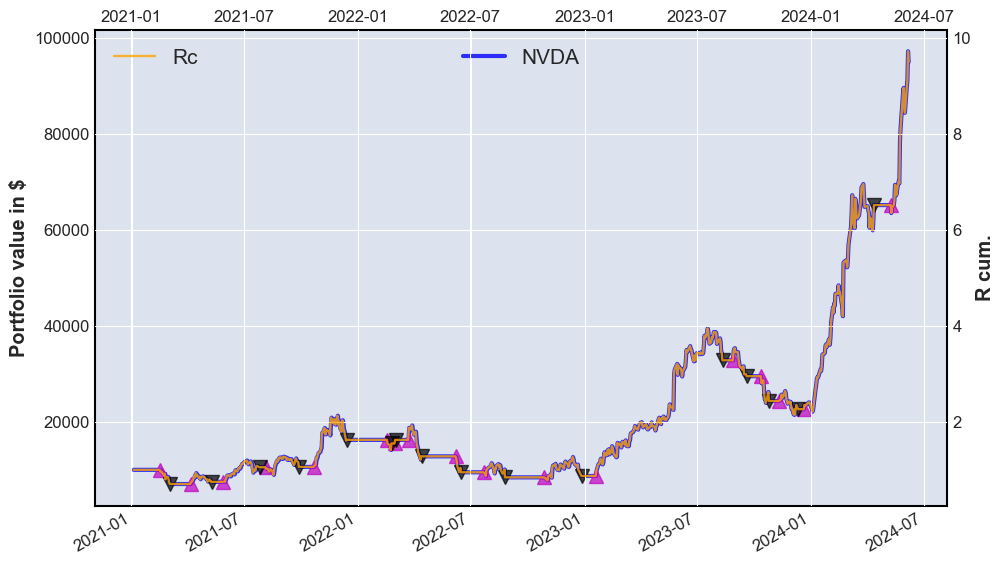

In [10]:
# portfolio value & cumulative returns (Rc) >>>

# Create a figure
fig = plt.figure(figsize=(11,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=3,alpha=0.8,label=tcr,color='b')
plt.legend(loc='upper center', fontsize=15)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.7)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.7)

ax2=fig.add_subplot(111, ylabel="R cum.", frame_on=False)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.yaxis.set_label_position('right')
ax2.plot(portfolio['Rc'], color='orange', alpha=0.8, lw=1.7,
         label="Rc")
plt.legend(loc='best', fontsize=15)

In [11]:
#
## benchmarking
#
'''
help(si.get_data)
'''
tcrspy="SPY"
dfpy=si.get_data(tcrspy, interval='1d', start_date=start)
print('\n', dfpy.columns, '\n\n', dfpy.index)



 Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object') 

 DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-05-23', '2024-05-24', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31', '2024-06-03', '2024-06-04',
               '2024-06-05', '2024-06-06'],
              dtype='datetime64[ns]', length=862, freq=None)


In [12]:
dfpy['R'] = dfpy[price].pct_change()
# cumulative returns >>
dfpy["Rc"] = (dfpy.R + 1).cumprod()

portfolio['holdings']
ind = portfolio[portfolio['holdings']>0].index.min()
ind
invest = portfolio['holdings'].loc[ind]
invest
print('\nFirst purchase was ', invest,' in', ind)

dfpy["tot_spy"] = initial_capital-invest + invest*dfpy["Rc"]
dfpy.tot_spy.iloc[0] = initial_capital

print('\n', dfpy)


First purchase was  15295.062255859375  in 2021-02-16 00:00:00

                   open        high         low       close    adjclose  \
2021-01-04  375.309998  375.450012  364.820007  368.790009  351.674469   
2021-01-05  368.100006  372.500000  368.049988  371.329987  354.096619   
2021-01-06  369.709991  376.980011  369.119995  373.549988  356.213531   
2021-01-07  376.100006  379.899994  375.910004  379.100006  361.506012   
2021-01-08  380.589996  381.489990  377.100006  381.260010  363.565796   
...                ...         ...         ...         ...         ...   
2024-05-31  523.590027  527.500000  518.359985  527.369995  527.369995   
2024-06-03  529.020020  529.309998  522.599976  527.799988  527.799988   
2024-06-04  526.460022  529.150024  524.960022  528.390015  528.390015   
2024-06-05  530.770020  534.690002  528.729980  534.669983  534.669983   
2024-06-06  534.979980  535.419983  533.240112  534.249878  534.249878   

               volume ticker         R       

C:\Users\mixas\AppData\Local\Temp\ipykernel_3268\2702890083.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpy.tot_spy.iloc[0] = initial_capital


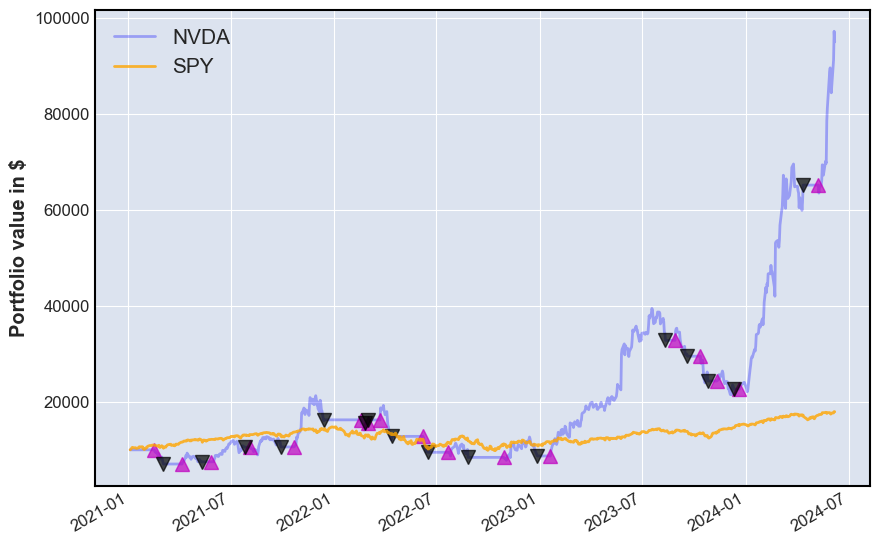

In [13]:
# cash & trading vs SPY investment >>>
# same scales on Y axis

# Create a figure
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.,alpha=0.3,label=tcr,color='b')

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.7)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.7)

ax1.plot(dfpy["tot_spy"], color='orange', alpha=0.8,
         label=tcrspy)

plt.legend(loc='best', fontsize=15)

In [14]:
print('\n', portfolio['total'],'\n', dfpy["tot_spy"])


 2021-01-04    10000.000000
2021-01-05    10000.000000
2021-01-06    10000.000000
2021-01-07    10000.000000
2021-01-08    10000.000000
                  ...     
2024-05-31    84358.255768
2024-06-03    89725.260162
2024-06-04    91162.259674
2024-06-05    97165.262604
2024-06-06    94940.714264
Name: total, Length: 862, dtype: float64 
 2021-01-04    10000.000000
2021-01-05    10105.344383
2021-01-06    10197.413374
2021-01-07    10427.594480
2021-01-08    10517.178815
                  ...     
2024-05-31    17641.367933
2024-06-03    17660.069218
2024-06-04    17685.730727
2024-06-05    17958.859754
2024-06-06    17940.588505
Name: tot_spy, Length: 862, dtype: float64


In [15]:
import webbrowser
import yahoo_fin.stock_info as si
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ta
import wbdata

In [16]:
## World Bank data
#

# run line by line... >>
wbdata.get_sources()
wbdata.get_indicators(source=2)

id                         name
-------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------
AG.AGR.TRAC.NO             Agricultural machinery, tractors
AG.CON.FERT.PT.ZS          Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS             Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2             Agricultural land (sq. km)
AG.LND.AGRI.ZS             Agricultural land (% of land area)
AG.LND.ARBL.HA             Arable land (hectares)
AG.LND.ARBL.HA.PC          Arable land (hectares per person)
AG.LND.ARBL.ZS             Arable land (% of land area)
AG.LND.CREL.HA             Land under cereal production (hectares)
AG.LND.CROP.ZS             Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2          Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS          Rural land area where elevation is below 5 me

In [17]:
#print('\n', wbdata.search_indicators("Consumer price index") )
print('\n', wbdata.get_indicators(query="Consumer price index", source=2) )
'''
FP.CPI.TOTL          Consumer price index (2010 = 100)
help(wbdata.get_dataframe)
'''
indicators = {'FP.CPI.TOTL': 'cpi'}
'''
d1 = datetime.datetime(s.year, 1, 1)
d2 = datetime.datetime(e.year, 1, 1)
cpi=wbdata.get_dataframe(indicators, data_date=(d1,d2),
                         country='USA')
'''
cpi=wbdata.get_dataframe(indicators, country='USA')
print('\n', cpi )

end = cpi.index.max()
end
# 4 years period >>
start = str(int(end)-4)
start

cpi.loc[start,]
cpi.loc[end,]

infl=pd.DataFrame(columns=('year','infl'))
base=int(start)
for i in range(base, int(end)+1):
  infl.loc[str(i),'year']=i
  infl.loc[str(i),'infl']=cpi.loc[str(i),'cpi']/cpi.loc[str(base),'cpi']
  print('\n', i, ' ', infl.loc[str(i),'infl'])

infl.index = pd.to_datetime(infl.index)


 id           name
-----------  ---------------------------------
FP.CPI.TOTL  Consumer price index (2010 = 100)

              cpi
date            
2023         NaN
2022  134.211206
2021  124.266414
2020  118.690502
2019  117.244195
...          ...
1964   14.224207
1963   14.044590
1962   13.872615
1961   13.708284
1960   13.563061

[64 rows x 1 columns]

 2019   1.0

 2020   1.0123358439630663

 2021   1.059893953138463

 2022   1.1447151445179404

 2023   nan


In [18]:
# get most active stocks on the day
ma = si.get_day_most_active()
print('\n', ma.columns,
      '\n\n', ma[['Symbol', 'Name', 'Volume']][:40])


 Index(['Symbol', 'Name', 'Price (Intraday)', 'Change', '% Change', 'Volume',
       'Avg Vol (3 month)', 'Market Cap', 'PE Ratio (TTM)'],
      dtype='object') 

    Symbol                                               Name      Volume
0     GME                                     GameStop Corp.  87964000.0
1     NIO                                           NIO Inc.  72086000.0
2    NVDA                                 NVIDIA Corporation  51590000.0
3    TSLA                                        Tesla, Inc.  49126000.0
4    MARA                    Marathon Digital Holdings, Inc.  46145000.0
5    PLTR                         Palantir Technologies Inc.  42185000.0
6     AMD                       Advanced Micro Devices, Inc.  35292000.0
7    NVAX                                      Novavax, Inc.  33119000.0
8    HOOD                            Robinhood Markets, Inc.  29823000.0
9    LYFT                                         Lyft, Inc.  28728000.0
10   RIOT                       


 Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object') 

 DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=1008, freq=None)


C:\Users\mixas\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


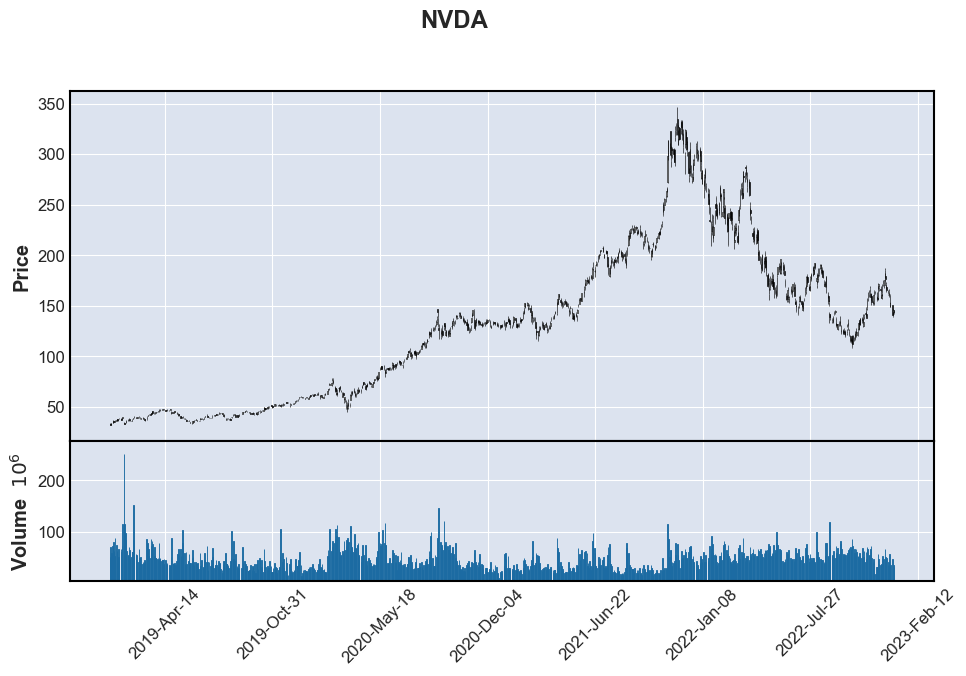

In [19]:
# get data >>>
#tcr='SNOW'
tcr='NVDA'

df=si.get_data(tcr, start_date=start, end_date=end, interval='1d')

print('\n', df.columns, '\n\n', df.index)

mpf.plot(df, type='candle', volume=True,
         main_panel=0, volume_panel=1, figsize=(12,7),
         show_nontrading=True, title=tcr)

In [20]:
# Initialize the short and long windows
short_window = 10
long_window = 30
price = 'adjclose'

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ta.trend.sma_indicator(df[price],
                                               window=short_window)

# Create long simple moving average over the long window
signals['long_mavg'] = ta.trend.sma_indicator(df[price],
                                               window=long_window)
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:],
                                            1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals,'\n\n',
      pd.crosstab(signals.signal, signals.positions))

            signal  short_mavg   long_mavg  positions
2019-01-02     0.0         NaN         NaN        NaN
2019-01-03     0.0         NaN         NaN        0.0
2019-01-04     0.0         NaN         NaN        0.0
2019-01-07     0.0         NaN         NaN        0.0
2019-01-08     0.0         NaN         NaN        0.0
...            ...         ...         ...        ...
2022-12-23     1.0  166.107506  163.871239        0.0
2022-12-27     0.0  162.695180  163.137658       -1.0
2022-12-28     0.0  158.661160  162.386416        0.0
2022-12-29     0.0  155.591666  161.700506        0.0
2022-12-30     0.0  153.254811  161.270073        0.0

[1008 rows x 4 columns] 

 positions  -1.0   0.0   1.0
signal                     
0.0          18   360     0
1.0           0   611    18


In [21]:
## short and long moving averages,
## together with the buy and sell signals

s = signals.index.min()
e = signals.index.max()
print('\nTime period to plot >>>\n', s,'\n', e)



Time period to plot >>>
 2019-01-02 00:00:00 
 2022-12-30 00:00:00


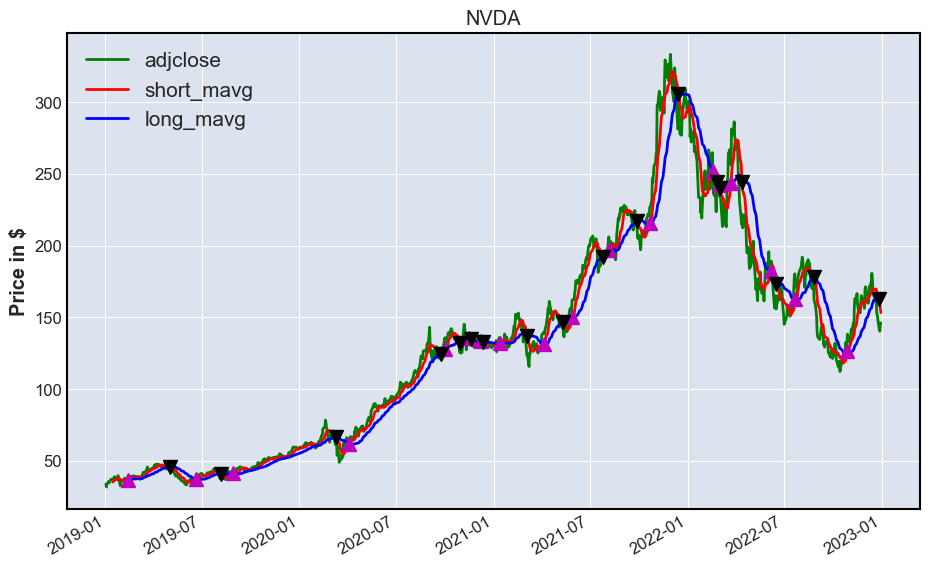

In [22]:
sp = signals.loc[s:e,]
dfp = df.loc[s:e,]

# Initialize the plot figure
fig = plt.figure(figsize=(11,7))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
dfp[price].plot(ax=ax1, color='g', lw=2., label=price)

# Plot the short and long moving averages
sp[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2., title=tcr,
                                     color=['r','b'])

# Plot the buy signals
ax1.plot(sp.loc[sp.positions == 1.0].index, 
         sp.short_mavg[sp.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(sp.loc[sp.positions == -1.0].index, 
         sp.short_mavg[sp.positions == -1.0],
         'v', markersize=10, color='k')
plt.legend(loc='best', fontsize=15)

In [23]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=sp.index).fillna(0.0)

# Would you buy *spd* shares a day?
spd = 100
positions[tcr] = spd*sp.signal
'''
print('\n',pd.crosstab(sp.signal, sp.positions))
print('\n',sp.groupby(by=['signal']).sum())
'''
  
# Initialize the portfolio with value owned, column *tcr*
# (store the market value of an open position) 
portfolio = positions.multiply(dfp[price], axis=0)

# Store the difference in shares owned
# (= +- *spd* in days when position was changed)
pos_diff = positions.diff()
'''
print('\n',pd.crosstab(positions[tcr], pos_diff[tcr]))
'''

# `holdings` in portfolio
# .sum(axis=1) --- сумма элементов в строках после умножения
portfolio['holdings'] = (positions.multiply(dfp[price],
                                            axis=0)).sum(axis=1)

# `cash` in portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(dfp[price],
                                       axis=0)).sum(axis=1).cumsum()   

# `total` portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# `returns` of portfolio
portfolio['R'] = portfolio['total'].pct_change()
portfolio['r'] = np.log1p(portfolio.R)
# cumulative returns >>
portfolio["Rc"] = (portfolio.R + 1).cumprod()
portfolio["rc"] = portfolio.r.cumsum()

# Print the first lines of `portfolio`
print(portfolio)

                    NVDA      holdings          cash         total         R  \
2019-01-02      0.000000      0.000000  10000.000000  10000.000000       NaN   
2019-01-03      0.000000      0.000000  10000.000000  10000.000000  0.000000   
2019-01-04      0.000000      0.000000  10000.000000  10000.000000  0.000000   
2019-01-07      0.000000      0.000000  10000.000000  10000.000000  0.000000   
2019-01-08      0.000000      0.000000  10000.000000  10000.000000  0.000000   
...                  ...           ...           ...           ...       ...   
2022-12-23  15198.542786  15198.542786   3830.110168  19028.652954 -0.006938   
2022-12-27      0.000000      0.000000  17944.186401  17944.186401 -0.056991   
2022-12-28      0.000000      0.000000  17944.186401  17944.186401  0.000000   
2022-12-29      0.000000      0.000000  17944.186401  17944.186401  0.000000   
2022-12-30      0.000000      0.000000  17944.186401  17944.186401  0.000000   

                   r        Rc        r

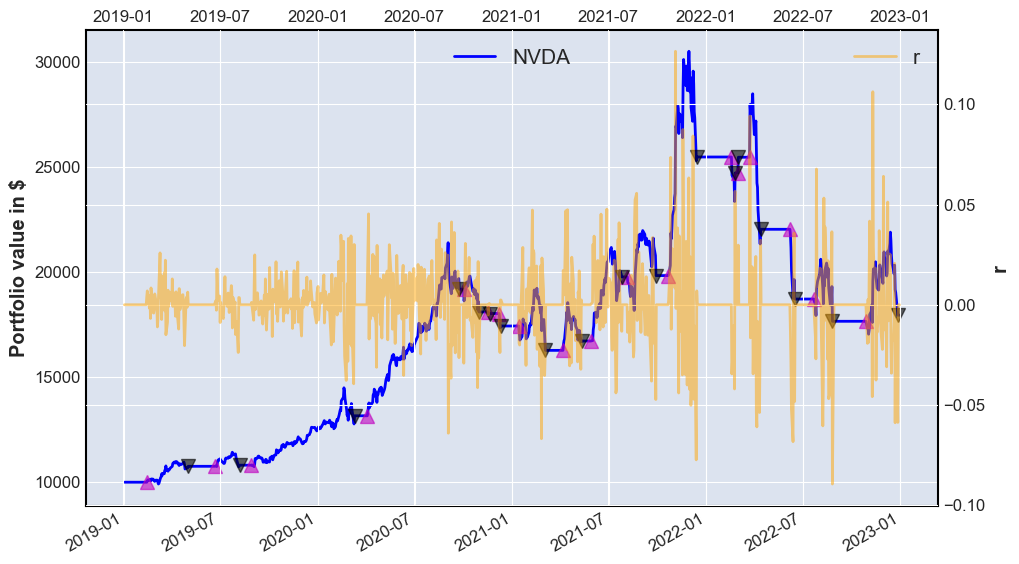

In [24]:
# visualize the portfolio value & returns >>>

# Create a figure
fig = plt.figure(figsize=(11,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2., label=tcr, color='b')
plt.legend(loc='upper center', fontsize=15)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.6)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.6)

ax2=fig.add_subplot(111, ylabel="r", frame_on=False)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.yaxis.set_label_position('right')
ax2.plot(portfolio['r'], color='orange', alpha=0.5, label="r")
plt.legend(loc='best', fontsize=15)

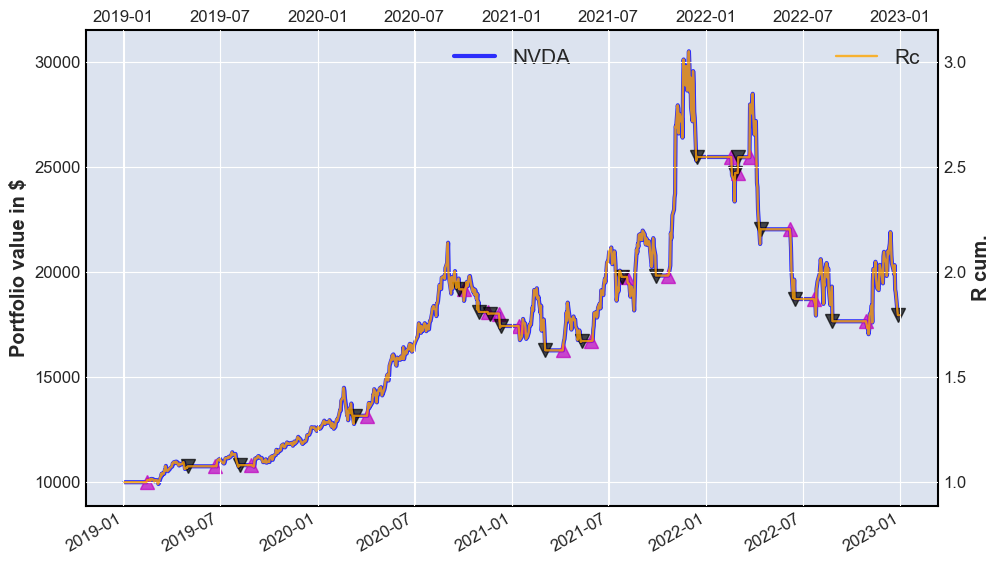

In [25]:
# portfolio value & cumulative returns (Rc) >>>

# Create a figure
fig = plt.figure(figsize=(11,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=3,alpha=0.8,label=tcr,color='b')
plt.legend(loc='upper center', fontsize=15)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.7)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.7)

ax2=fig.add_subplot(111, ylabel="R cum.", frame_on=False)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.yaxis.set_label_position('right')
ax2.plot(portfolio['Rc'], color='orange', alpha=0.8, lw=1.7,
         label="Rc")
plt.legend(loc='best', fontsize=15)

In [26]:
#
## benchmarking
#
'''
help(si.get_data)
'''
tcrspy="SPY"
dfpy=si.get_data(tcrspy, interval='1d', start_date=start, end_date=end)
print('\n', dfpy.columns, '\n\n', dfpy.index)


 Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object') 

 DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=1008, freq=None)


In [27]:
dfpy['R'] = dfpy[price].pct_change()
# cumulative returns >>
dfpy["Rc"] = (dfpy.R + 1).cumprod()

portfolio['holdings']
ind = portfolio[portfolio['holdings']>0].index.min()
ind
invest = portfolio['holdings'].loc[ind]
invest
print('\nFirst purchase was ', invest,' in', ind)

dfpy["tot_spy"] = initial_capital-invest + invest*dfpy["Rc"]
dfpy.tot_spy.iloc[0] = initial_capital

print('\n', dfpy)


First purchase was  3792.134475708008  in 2019-02-13 00:00:00

                   open        high         low       close    adjclose  \
2019-01-02  245.979996  251.210007  245.949997  250.179993  229.843292   
2019-01-03  248.229996  248.570007  243.669998  244.210007  224.358612   
2019-01-04  247.589996  253.110001  247.169998  252.389999  231.873688   
2019-01-07  252.690002  255.949997  251.690002  254.380005  233.701920   
2019-01-08  256.820007  257.309998  254.000000  256.769989  235.897598   
...                ...         ...         ...         ...         ...   
2022-12-23  379.649994  383.059998  378.029999  382.910004  376.009155   
2022-12-27  382.790009  383.149994  379.649994  381.399994  374.526367   
2022-12-28  381.329987  383.390015  376.420013  376.660004  369.871796   
2022-12-29  379.630005  384.350006  379.079987  383.440002  376.529572   
2022-12-30  380.640015  382.579987  378.429993  382.429993  375.537781   

               volume ticker         R        

C:\Users\mixas\AppData\Local\Temp\ipykernel_3268\2702890083.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpy.tot_spy.iloc[0] = initial_capital


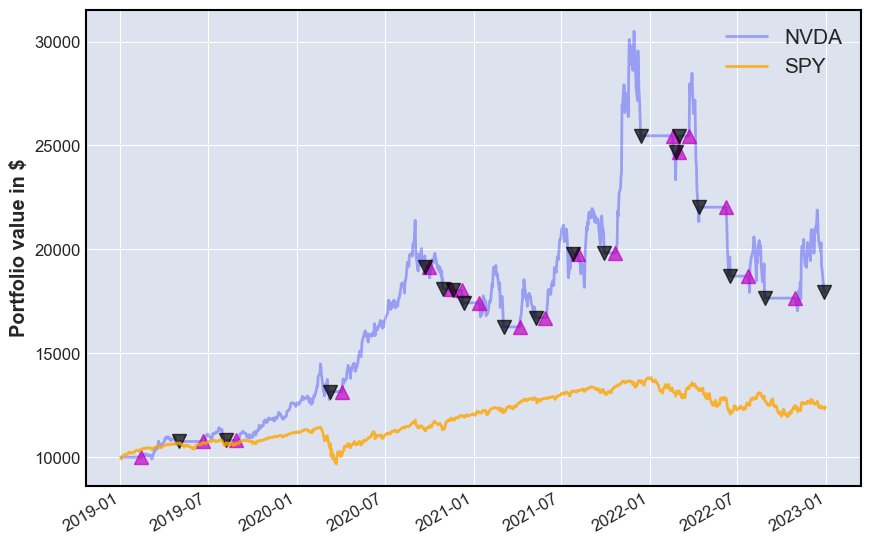

In [28]:
# cash & trading vs SPY investment >>>
# same scales on Y axis

# Create a figure
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2,alpha=.3,label=tcr,color='b')

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.7)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.7)

ax1.plot(dfpy["tot_spy"], color='orange', alpha=0.8,
         label=tcrspy)

plt.legend(loc='best', fontsize=15)

In [29]:
print('\n', portfolio['total'],'\n', dfpy["tot_spy"])


 2019-01-02    10000.000000
2019-01-03    10000.000000
2019-01-04    10000.000000
2019-01-07    10000.000000
2019-01-08    10000.000000
                  ...     
2022-12-23    19028.652954
2022-12-27    17944.186401
2022-12-28    17944.186401
2022-12-29    17944.186401
2022-12-30    17944.186401
Name: total, Length: 1008, dtype: float64 
 2019-01-02    10000.000000
2019-01-03     9909.509455
2019-01-04    10033.499054
2019-01-07    10063.662653
2019-01-08    10099.888678
                  ...     
2022-12-23    12411.558776
2022-12-27    12387.094578
2022-12-28    12310.299814
2022-12-29    12420.145010
2022-12-30    12403.781670
Name: tot_spy, Length: 1008, dtype: float64



SPY  24.04 %
NVDA  79.44 % 
Inflation (CPI) nan %


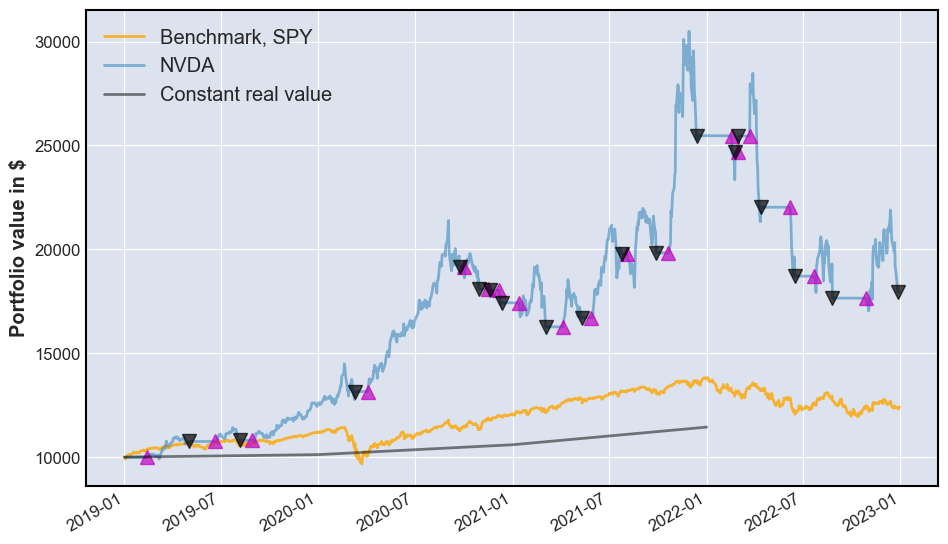

In [30]:
# Nominal returns
Rb=np.round(100*((dfpy.iloc[-1]['tot_spy']/dfpy.iloc[0]['tot_spy'])-1), 2)
Rp=np.round(100*((portfolio.iloc[-1]['total']/portfolio.iloc[0]['total'])-1),2)
# inflation
Ri=np.round(100*((infl.iloc[-1]['infl']/infl.iloc[0]['infl'])-1),2)
# constant real value curve
infl['crv']=infl['infl']*initial_capital


# Create a figure
fig = plt.figure(figsize=(11,7))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
ax1.plot(dfpy["tot_spy"], color='orange', alpha=0.8,
         label="Benchmark, "+tcrspy)
portfolio['total'].plot(ax=ax1, lw=2., alpha=0.5, label=tcr)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.7)
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.7)
ax1.plot(infl['crv'], color='k', alpha=0.5, label="Constant real value")
plt.legend(fontsize='large', shadow=True)

print('\n'+tcrspy+' ', Rb, '%\n'+tcr+' ', Rp, '%',
      '\nInflation (CPI)', Ri, '%')

In [31]:
!pip install backtrader
!pip show backtrader

  Obtaining dependency information for backtrader from https://files.pythonhosted.org/packages/f3/ef/328c6ec332435f63b3e18febd263686b8ba07e990676a862cc8522ba38f5/backtrader-1.9.78.123-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/419.5 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/419.5 kB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 204.8/419.5 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 419.5/419.5 kB 3.3 MB/s eta 0:00:00
Name: backtrader
Version: 1.9.78.123
Summary: BackTesting Engine
Home-page: https://github.com/mementum/backtrader
Author: Daniel Rodriguez
Author-email: danjrod@gmail.com
License: GPLv3+
Location: C:\Users\mixas\anaconda3\Lib\site-packages
Requires: 
Required-by: 


In [2]:
import webbrowser
import yahoo_fin.stock_info as si
import backtrader as bt

In [3]:
class PandasData(bt.feed.DataBase):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('adjclose', -1),
        ('volume', -1),
        ('openinterest', -1),
    )

In [4]:
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

In [8]:
## get data from "Yahoo! Finance" >>>
#
#tcr='SNOW'
tcr='NVDA'

start='2019-1-1'
'''
start='2019-12-01'
end = '2020-09-01'
df=si.get_data(tcr, start_date=start, end_date=end)
'''
df=si.get_data(tcr, start_date=start)
df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [9]:
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

dc = bt.feeds.PandasData(dataname=df)

cerebro.adddata(dc, tcr)

cerebro.run()

In [10]:
"""
# Choose by hand in Spyder ->
# Tools -> Preferences -> IPython Console -> Graphics backend
#  Backend: 'Automatic'
"""
cerebro.plot(iplot= False)

[[<Figure size 1148x600 with 5 Axes>]]